# Libraries

In [1]:
import os
import sys
import glob
import pickle

import copy as cp
import itertools as it

import seaborn as sns
import numpy   as np
import pandas  as pd
import healpy  as hp

from astropy.io import fits
from astropy.wcs import WCS
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

from spectral_cube import SpectralCube

import scipy
import pickle

import matplotlib.pyplot as plt
import matplotlib        as mpl

plt.rcParams["font.family"] = 'STIXGeneral'

from astropy.io.votable import from_table, parse_single_table, parse
from matplotlib.ticker  import AutoMinorLocator    

import h5py as h5
import pwlf

from pathlib import Path
import more_itertools as mit

# Paths

In [5]:
base = Path.home()
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

cont_data_path = data_path / 'cont'
LMC_bridge_data = LMC_data_path / 'bridge'
GASS_em_spectra_path = LMC_data_path / 'neighbour_emission_spectra'
GASS_data_path = LMC_data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'

hires_data = LMC_data_path / 'hires'
em_spectra_path = hires_data / 'neighbour_emission_spectra'
hires_results = hires_data / 'results'
hires_em_data = hires_data / 'cube'
hires_em_subcube_data = hires_em_data / 'subcubes'
hires_abs_data = hires_data / 'abs'
hires_em_profile_path = hires_data / 'em_profiles'
abscatv2_data_path = hires_data / 'abscatv2'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'

abs_path = mwmc_data_path / 'absorption'

abs_path = mwmc_data_path / 'absorption'
BIGHICAT_data_path = data_path / 'BIGHICAT'


dust_data_path = data_path / 'dust'
planck_data_path = dust_data_path / 'planck'
edenhofer_dust_data_path = dust_data_path / 'edenhofer'

# Absorption catalog Phase 2 version 2
print(abscatv2_data_path)

# Absorption catalog  version 3
print(abs_dr3_data_path)

/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abscatv2
/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/absdr3


In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = os.path.join( parent_dir, 'gaussfit')
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = os.path.join( parent_dir, 'gaussfit', 'modules')
sys.path.append(module_dir)
script_dir

In [7]:
import gaussfit.modules.decomposer as dc
import gaussfit.modules.fit as find_gcomp
import libs.fitlibs as fitlibs
import config.config as cf

sys.path.append(parent_dir)

from mpfit import mpfit

# Fcn

In [9]:
def read_fits_cube(filename):
    """
    Read 

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """
        
    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube
    

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    
    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close()

    print(f"Cube shape: {c.shape}")

    del dat
    
    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]     # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]    # extract velocity
    
    return c, w, x, y, v, hdr

In [10]:
def get_axes_1D(hdr):
    # Define the parameters
    grid_size = hdr['NAXIS1']
    reference_value = hdr['CRVAL1']
    ref_pixel = hdr['CRPIX1']
    step = hdr['CDELT1']

    # Calculate the pixel values
    xvalues = np.array([reference_value + (i+1 - ref_pixel) * step for i in range(grid_size)])

    # Define the parameters
    grid_size = hdr['NAXIS2']
    reference_value = hdr['CRVAL2']
    ref_pixel = hdr['CRPIX2']
    step = hdr['CDELT2']

    # Calculate the pixel values
    yvalues = np.array([reference_value + (i+1 - ref_pixel) * step for i in range(grid_size)])

    # Print the pixel values
    return xvalues, yvalues

In [ ]:
# Define customized function
def avg_std(col):
    return np.sqrt(np.sum(col**2))

# For plotting

In [11]:
# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = cf.SMC['circ']
LMC_xcirc, LMC_ycirc = cf.LMC['circ']

In [12]:
# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

In [13]:
lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Fcn

In [16]:
def boostrap_resampling_err(data):
    # Define the number of bootstrap samples
    n_bootstrap_samples = 1000

    # Initialize array to store resampled medians
    resampled_medians = np.empty(n_bootstrap_samples)

    # Initialize array to store resampled means
    resampled_means = np.empty(n_bootstrap_samples)

    # Perform bootstrap resampling
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        resampled_medians[i] = np.median(bootstrap_sample)
        resampled_means[i] = np.mean(bootstrap_sample)
    # Endfor

    median_uncertainty = np.std(resampled_medians)
    mean_uncertainty = np.std(resampled_means)
    print("mean_uncertainty: ", mean_uncertainty)
    print("median_uncertainty: ", median_uncertainty)
    return mean_uncertainty, median_uncertainty

In [17]:
# linear model
def linear_fcn(p, x):
    m, b = p
    return m*x + b

# Read BIGHICAT

In [18]:
bighicat_file = os.path.join(BIGHICAT_data_path, 'all_unique_LOS_new.csv')
bighicat_df = pd.read_csv(bighicat_file)
bighicat_df = bighicat_df[bighicat_df.lat.notnull()]
bighicat_nrows, bighicat_ncols = bighicat_df.shape
print(bighicat_nrows, bighicat_ncols)

373 30


In [21]:
bighicat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [19]:
bighicat_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,...,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,...,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,...,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,...,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,...,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,J17304,MACH,75.772200,33.067700,262.685109,49.106959,2.500000,0.120000,0.880000,0.300000,...,0.041254,0.127889,-17.716097,-0.306228,-0.234197,17.608982,0.372730,0.057,NaN,NaN
369,J17305,MACH,62.989300,31.515300,262.725150,38.197218,3.340000,0.080000,0.920000,0.267200,...,0.048668,0.150870,-6.611929,-0.689890,0.163849,18.828846,0.375549,0.055,NaN,NaN
370,J17395,MACH,74.222100,31.396300,264.987619,47.632615,2.100000,0.010000,0.990000,0.021000,...,0.024448,0.075789,-4.240314,-0.046202,-1.399806,16.961460,0.294231,0.074,NaN,NaN
371,J17403,MACH,79.563300,31.748300,265.153694,52.195089,2.930000,0.010000,0.990000,0.029300,...,0.049554,0.153618,-17.370651,-0.365892,-1.449508,18.306437,0.388935,0.059,NaN,NaN


In [20]:
bighicat_fcnm = bighicat_df['f_CNM_LOS']
bighicat_av = bighicat_df['AV_2013']
bighicat_gl = bighicat_df['lon']
bighicat_gb = bighicat_df['lat']

# GASKAP: Read table DR3

In [21]:
spectra_filename = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
print(spectra_filename)
df = pd.read_csv(spectra_filename)
nsrcs, ncols = df.shape
print(f'Number of rows {nsrcs},\n Number of columns: {ncols}')
df.head(5)

/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of rows 2714,
 Number of columns: 33


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [32]:
src_ra = df['ra'].values
src_dec = df['dec'].values

src_gl = df['glon'].values
src_gb = df['glat'].values

src_list = df['comp_name'].values
print(len(src_list))

2714


In [33]:
fields_series = df['sbid'].value_counts()
fields_series

30665    346
38791    297
33047    290
38845    283
38509    270
38215    268
38466    261
38373    257
38814    242
38758    200
Name: sbid, dtype: int64

In [34]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [35]:
df[ df['has_mw_abs'] == True ]['comp_name'].unique().shape

(473,)

In [36]:
sbid = fields_series.index.to_list()
print(f'Fields: {sbid}')
sbid_counts = fields_series.values
print(f'sbid_counts: {sbid_counts}')

Fields: [30665, 38791, 33047, 38845, 38509, 38215, 38466, 38373, 38814, 38758]
sbid_counts: [346 297 290 283 270 268 261 257 242 200]


In [38]:
print(f"Types of ratings: {df['rating'].unique()}")

rating_info = df['rating'].value_counts()
rating_types = rating_info.index.to_list()
print(f'Rating types: {rating_types}')

rating_counts = rating_info.values
print(f'Rating counts: {rating_counts}')

n_ratings = len(rating_types)

Types of ratings: ['A' 'B' 'C' 'D']
Rating types: ['B', 'C', 'A', 'D']
Rating counts: [1869  343  294  208]


# Dectections

In [40]:
det_df = df[df.mw_detection]
print(det_df.shape)
ndet = det_df.shape[0]

det_src_list = det_df.comp_name.values
det_src_gl = det_df.glon.values
det_src_gb = det_df.glat.values

(462, 33)


In [41]:
nsrcs

2714

# Saturated sources

In [42]:
sat_df = df[df.saturated]
sat_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
1462,337,J033454-765712,SB38509_component_225a,53.727799,-76.953516,292.330669,-36.594138,B,18.247999,27.194000,...,4.850,176.830002,2.441017e+20,False,0.009408,M355-07,38509,38509,False,True
1565,244,J042645-754356,SB38758_component_131a,66.689082,-75.732415,288.902586,-34.845820,C,31.113001,34.987999,...,4.260,55.369999,2.455275e+20,False,0.011692,M355-02,38758,38758,False,True
1576,287,J040852-721901,SB38758_component_156a,62.220323,-72.317006,286.012697,-37.626103,C,25.906000,32.137001,...,4.465,65.930000,1.192325e+20,False,0.012949,M355-02,38758,38758,False,True
1603,362,J035607-735425,SB38758_component_210a,59.030638,-73.907151,288.329734,-37.514114,C,19.132999,24.773001,...,4.540,42.380001,2.405412e+20,False,0.009862,M355-02,38758,38758,False,True
2040,350,J040428-692618,SB38814_component_209a,61.118584,-69.438462,283.100898,-39.422719,C,20.837000,24.475000,...,4.100,54.599998,4.971288e+19,False,0.002216,M355+02,38814,38814,False,True
2147,110,J053821-771905,SB38845_component_63a,84.590892,-77.318269,288.944277,-30.404877,C,55.574001,69.519997,...,4.570,40.900002,1.832042e+20,False,0.014752,M000-02,38845,38845,False,True
2148,111,J053821-771856,SB38845_component_63b,84.588785,-77.315712,288.941479,-30.405840,C,42.478001,54.595001,...,4.620,44.450001,1.832042e+20,False,0.013924,M000-02,38845,38845,False,True
2234,274,J045859-754650,SB38845_component_171b,74.746789,-75.780713,287.956296,-33.026360,B,16.715000,24.173000,...,4.970,31.719999,2.820502e+20,False,-0.003037,M000-02,38845,38845,False,True
2324,442,J061332-742400,SB38845_component_289a,93.385278,-74.400240,285.348760,-28.592825,C,15.986000,25.902000,...,5.050,74.209999,7.335645e+19,True,0.006051,M000-02,38845,38845,False,True
2383,0,J032723-744843,SB38509_component_138a,51.846610,-74.812165,290.789024,-38.410531,C,27.474001,28.622999,...,4.230,41.660000,0.000000e+00,False,-0.010134,M355-07,"38466,38509,38758",38509,False,True


In [43]:
sat_gl = sat_df.glon.values
sat_gb = sat_df.glat.values

In [44]:
nsat = len(sat_gl)
nsat

12

# GASKAP Tbpeak

In [50]:
outfile1 = LMC_data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
nx1 = 5100
nx2 = 3500

In [52]:
print(outfile1)
tbpeak_data, fg_hdr = fits.getdata(outfile1, header=True)
print(tbpeak_data.shape)
fg_hdr

/Users/kiemhiep/ANU/ASKAP/data/LMC/Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits
(3500, 5100)


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5100                                                  
NAXIS2  =                 3500                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               2550.0 / Pixel coordinate of reference point            
CRPIX2  =               1750.0 / Pixel coordinate of reference point            
CDELT1  =          -0.00666666 / [deg] Coordinate increment at reference point  
CDELT2  =           0.00666666 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'GLON-TAN'        

# Detections

In [54]:
field_det = {
    0 : [30665, 'gaskap_phase2_abs_catalogue_field0_30665_dr3.csv', ['J005337-723143', 'J011056-731406', 'J005611-710706', 'J005238-731244']], # SMC
    1 : [38373, 'gaskap_phase2_abs_catalogue_field1_38373_dr3.csv', ['J044512-654707', 'J044056-662423', 'J050504-641830']],
    2 : [38791, 'gaskap_phase2_abs_catalogue_field2_38791_dr3.csv', ['J054030-631513', 'J053249-634813']],
    3 : [38814, 'gaskap_phase2_abs_catalogue_field3_38814_dr3.csv', ['J035150-695934']],
    4 : [33047, 'gaskap_phase2_abs_catalogue_field4_33047_dr3.csv', ['J060111-703609', 'J053943-693847', 'J051832-693524']],
    5 : [38758, 'gaskap_phase2_abs_catalogue_field5_38758_dr3.csv', ['J040848-750719', 'J044025-762044', 'J040848-750719', 'J043534-745200', 'J035801-760516']],
    6 : [38845, 'gaskap_phase2_abs_catalogue_field6_38845_dr3.csv', ['J045438-751726', 'J052929-724528', 'J045859-754650', 'J054150-733215', 'J054150-733215', 'J061012-743157', 'J045438-751726']],
    7 : [38509, 'gaskap_phase2_abs_catalogue_field7_38509_dr3.csv', ['J031155-765150']],
    8 : [38466, 'gaskap_phase2_abs_catalogue_field8_38466_dr3.csv', ['J025246-710435', 'J025246-710431', 'J025245-710432', 'J025246-710434', 'J031610-682104']],
    9 : [38215, 'gaskap_phase2_abs_catalogue_field9_38215_dr3.csv', ['J012256-751507', 'J010249-795604']]
}

# Results: Integrated properties along lines of sight

In [55]:
csv_filename   = hires_results / 'hires_result_table_dr3.csv' # DR3
mc_fg_res_df = pd.read_csv(csv_filename)

ndet_total, ncols = mc_fg_res_df.shape

print('Number of sightlines with detections: ', ndet_total, '| ncols: ', ncols)
mc_fg_res_df.head(5)

Number of sightlines with detections:  462 | ncols:  42


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.114780,0.009487,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.346858,0.114980,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.130709,0.015873,1.013608,0.058216,2.736283,0.139665,2.701180,0.069134,1,3.485386
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,...,0.236581,0.042168,0.996616,0.161232,3.658516,0.577369,3.670527,0.119231,1,3.473220


In [56]:
sources = mc_fg_res_df['comp_name'].values
nabs_sources = len(sources)
nabs_sources

462

In [57]:
mc_fg_res_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi', 'signhi', 'nhi_thin',
       'signhi_thin', 'ncnm', 'tsky'],
      dtype='object')

In [58]:
uniq_sources = mc_fg_res_df['comp_name'].unique()
nabs_uniq_sources = len(uniq_sources)
nabs_uniq_sources

462

In [59]:
assert nabs_sources == nabs_uniq_sources

In [61]:
mc_src_gl = mc_fg_res_df['glon'].values
mc_src_gb = mc_fg_res_df['glat'].values

ew = mc_fg_res_df['ew'].values
sigew = mc_fg_res_df['sigew'].values
ewfit = mc_fg_res_df['ewfit'].values
sigewfit = mc_fg_res_df['sigewfit'].values

fields = mc_fg_res_df['sbid'].unique()
nfields = len(fields)
nfields

10

In [63]:
src_fields = mc_fg_res_df['sbid'].values
len(src_fields)

462

In [64]:
# Lines-of-sight towards the SMC foreground
smc_src_gl = mc_fg_res_df[mc_fg_res_df['sbid'] == 0]['glon']
smc_src_gb = mc_fg_res_df[mc_fg_res_df['sbid'] == 0]['glat']
n_smc_fg_srcs = len(smc_src_gb)

In [65]:
n_lmc_fg_srcs = nabs_sources - n_smc_fg_srcs
print(n_smc_fg_srcs)
print(n_lmc_fg_srcs)

0
462


# Result DR3: CNM components

In [68]:
csv_filename = hires_results / 'hires_result_CNM_components_dr3.csv' # DR3
mc_fg_cpn_df = pd.read_csv(csv_filename)

total_ncnm, ncols = mc_fg_cpn_df.shape

print('Number of CNM components detected: ', total_ncnm, '| ncols: ', ncols)
mc_fg_cpn_df.head(5)

Number of CNM components detected:  691 | ncols:  39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [71]:
# Group by 'Group' and calculate the mean of 'Value1' and the sum of 'Value2'
result = mc_fg_cpn_df.groupby('comp_name').agg({'tscnm': 'mean', 'sigtscnm': avg_std})
result = result.reset_index().sort_values('comp_name')
tspin_mean = result['tscnm'].values
sigtspin_mean = result['sigtscnm'].values

result

,comp_name,tscnm,sigtscnm
0,J001424-733911,65.796504,20.377934
1,J002144-741500,49.595013,24.222079
2,J002223-742825,80.899866,13.880308
3,J002248-734007,52.051044,6.355195
4,J002335-735529,53.248983,13.350175
...,...,...,...
457,J061014-743208,48.052885,2.317335
458,J061014-743214,46.280037,2.128937
459,J061024-711917,81.266014,38.546841
460,J061030-700235,46.344885,10.392683


In [72]:
assert np.all(result['comp_name'].isin(src_list))
np.all(result['comp_name'].isin(src_list))

True

# Read dust data: 3D dust map Edenhoper et al. 2023

3D dust map from Gordian Edenhofer 2024

In [73]:
# V-band (visual filter) averaged at a wavelength of 540 nm, 542.0 factor = 2.766111135482788, 551nm : 2.658158779144287
# % extinction_curve.txt
# % https://zenodo.org/records/7811871

In [74]:
dri = 1.
distance = np.arange(69., 1251., dri)
dri = 0.496218487394958
distance = np.arange(69., 1250.+dri, dri)
print(distance.shape)
distance

(2381,)


array([  69.        ,   69.49621849,   69.99243697, ..., 1249.00756303,
       1249.50378151, 1250.        ])

In [ ]:
filename = edenhofer_dust_data_path / 'int_mcfg_data_1250pc.fits'
filename

In [76]:
dust_data, hdr = fits.getdata(filename, header=True)
av_map = 2.658158779144287*dust_data*dri
dust_data.shape

(786, 1572)

In [77]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1572                                                  
NAXIS2  =                  786                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                787.0 / Pixel coordinate of reference point            
CRPIX2  =                394.0 / Pixel coordinate of reference point            
CDELT1  =    0.025445292620865 / [deg] Coordinate increment at reference point  
CDELT2  =    0.029262086513995 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'GLON-CAR'        

In [ ]:
GLON, GLAT = get_axes_1D(hdr)
GLON = np.where(GLON < 0., GLON + 360., GLON)
print('Glon:')
print(GLON)
print()
print('Glat:')
print(GLAT)
print()


# Create a meshgrid of pixel coordinates
GLON, GLAT = np.meshgrid(GLON, GLAT, indexing='xy')

GLON = GLON.flatten()
GLAT = GLAT.flatten()
av = av_map.flatten()
print('Av: ', av)
print()

In [ ]:
nside = 256
nside = 1024
theta = np.radians(90. - GLAT)
phi   = np.radians(GLON)
pix_indices = hp.ang2pix(nside, theta, phi, nest=False)
print('pix_indices: ', pix_indices)
npix = hp.nside2npix(nside)


fig = plt.figure(figsize=(16, 12))

# Accumulate the data for each HEALPix index
hp_map = np.bincount(pix_indices, minlength=npix)

# Visualize the HEALPix map using mollview
hp.mollview(hp_map, title='HEALPix Map')
# plt.savefig(base_path / f'hp_map_bincount.png', bbox_inches='tight')   # save the figure to file
plt.show()
plt.close('all')

In [81]:
# Compute the average value of the data at each HEALPix pixel
hp_data = np.zeros(npix)
for i, pix_id in enumerate(pix_indices):
    hp_data[pix_id] += av[i]

# Normalize by the number of contributions to each Healpix pixel
counts = np.bincount(pix_indices.ravel(), minlength=npix)
nonzero = counts > 0
hp_data[nonzero] /= counts[nonzero]

In [ ]:
plt.figure(figsize=(16, 12))

# Visualize the HEALPix map using mollview
hp.mollview(hp_data, title='$A_V$ (1248 pc)', cmap='hot', unit='$A_V$ [mag]', min=0., max=4.25) # , min=0., max=4.25 norm='log', 

if True:
    hp.projplot(mc_src_gl, mc_src_gb, 'bx', lonlat=True, coord='G')

mpl.rcParams.update({'font.size':12})
plt.show()
plt.close('all')

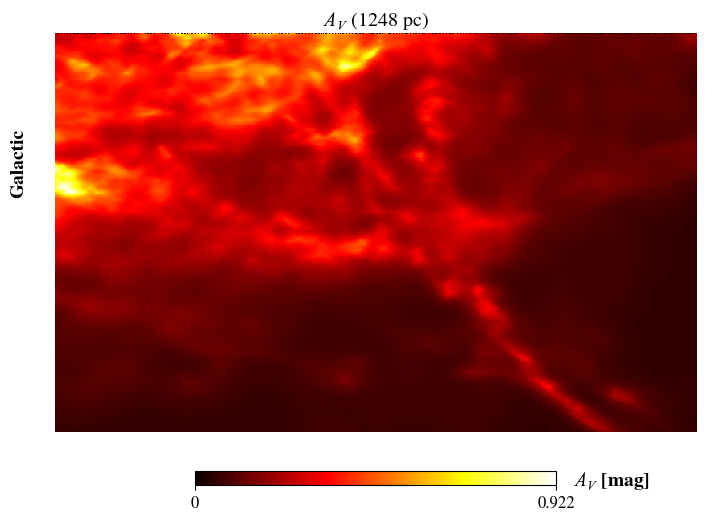

In [84]:
#====== For Plotting ======#
lmc_glon = [270., 307.]
lmc_glat = [-48., -25.]
glon_cen = (lmc_glon[0]+lmc_glon[1])/2.
glat_cen = (lmc_glat[0]+lmc_glat[1])/2.

hp.cartview(hp_data, title='$A_V$ (1248 pc)', coord=['G'], unit=r'$A_{V}$ [mag]', nest=False,
            lonra=lmc_glon, latra=lmc_glat, cmap='hot', min=0., cbar=True)

mpl.rcParams.update({'font.size':12})
plt.grid()
plt.show()

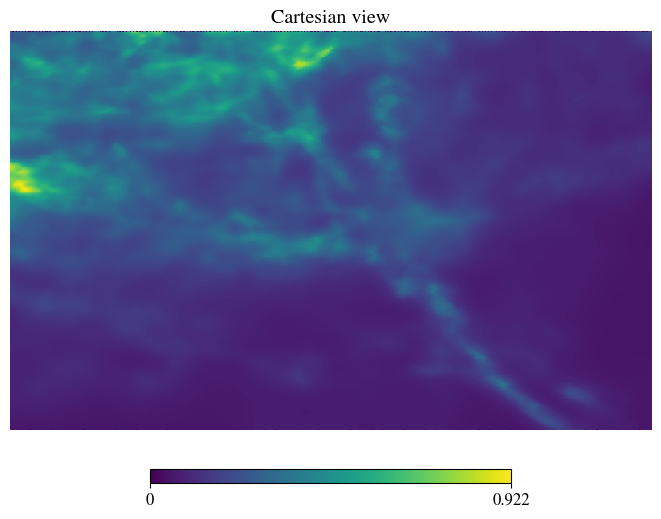

In [85]:
test = hp.cartview(hp_data, return_projected_map=True, lonra=lmc_glon, latra=lmc_glat, norm='line')

In [87]:
fcnm = mc_fg_res_df['fcnm'].values
sigfcnm = mc_fg_res_df['sigfcnm'].values
fcnm.shape

(462,)

In [88]:
nhi = mc_fg_res_df['nhi'].values
signhi = mc_fg_res_df['signhi'].values
nhi.shape

(462,)

In [ ]:
gl_coords = SkyCoord(mc_src_gl, mc_src_gb, frame='galactic', unit='deg')
print(gl_coords)

In [90]:
wcs2D = WCS(hdr)
print(wcs2D)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR'  'GLAT-CAR'  
CRVAL : -70.0  -36.5  
CRPIX : 787.0  394.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.025445292620865  0.029262086513995  
NAXIS : 1572  786


In [ ]:
print(gl_coords)
x, y = gl_coords.to_pixel(wcs=wcs2D)
print(x)
print(y)
x = np.round(x).astype(int)
y = np.round(y).astype(int)
print(x)
print(y)

print(x[0])
print(y[0])

In [93]:
LMC_center_gl = cf.LMC['gl'] # deg
LMC_center_gb = cf.LMC['gb'] # deg

In [ ]:
src_av = np.zeros(nabs_sources)
for k, (srci, xi, yi, gli, gbi) in enumerate(zip(sources, x, y, mc_src_gl, mc_src_gb)):
    print(k, xi, yi, av_map[yi, xi])
    src_av[k] = av_map[yi, xi]

In [96]:
src_sigav = src_av*0.08
sigfcnm_log10 = sigfcnm/fcnm/np.log(10)
sigAv_log10 = src_sigav/src_av/np.log(10)

# Read dust data: SFD1998

In [99]:
import dustmaps.bayestar
from dustmaps.sfd import SFDQuery

In [ ]:
coords = SkyCoord(mc_src_gl, mc_src_gb, unit='deg', frame='galactic')
sfd = SFDQuery()
sfd(coords)

In [ ]:
# See Section 2.1.1: https://iopscience.iop.org/article/10.3847/1538-4357/aa84af/pdf
# ANd here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/EWCNL5
# Factor: 2.742 to convert ebv to Av, or E(B-V) = 0.884 * E(B-V)_SFD, R=3.1
Av = sfd(coords)*2.742
sigAv = Av*0.16
Av

In [102]:
mc_fg_res_df['sgd_av'] = Av.tolist()
mc_fg_res_df['sgd_sigav'] = sigAv.tolist()
mc_fg_res_df.head()

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,sgd_av,sgd_sigav
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176,0.113332,0.009067
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591,0.289597,0.023168
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467,0.116612,0.009329
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,1.013608,0.058216,2.736283,0.139665,2.701180,0.069134,1,3.485386,0.122936,0.009835
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,...,0.996616,0.161232,3.658516,0.577369,3.670527,0.119231,1,3.473220,0.154984,0.012399


In [ ]:
# See Section 2.1.1: https://iopscience.iop.org/article/10.3847/1538-4357/aa84af/pdf
# ANd here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/EWCNL5
# Factor: 2.742 to convert ebv to Av, or E(B-V) = 0.884 * E(B-V)_SFD, R=3.1
bighicat_coords = SkyCoord(bighicat_gl, bighicat_gb, unit='deg', frame='galactic')
bighicat_Av = sfd(bighicat_coords)*2.742
bighicat_sigAv = bighicat_Av*0.16
bighicat_Av

## $F_{CNM}$, $N_{HI}$ and coordinates

In [104]:
fcnm = mc_fg_res_df['fcnm'].values
sigfcnm = mc_fg_res_df['sigfcnm'].values
fcnm.shape

(462,)

In [105]:
nhi = mc_fg_res_df['nhi'].values
signhi = mc_fg_res_df['signhi'].values
nhi.shape

(462,)

# $F_{CNM}$ vs $A_V$: far from LMC and SMC

In [114]:
SMC_center_gl = cf.SMC['gl'] # deg
SMC_center_gb = cf.SMC['gb'] # deg
print(SMC_center_gl, SMC_center_gb)

302.0 -44.5


In [115]:
print(cf.R_SMC, cf.R_LMC)

3.0 5.0


In [116]:
LMC_center_gl = cf.LMC['gl'] # deg
LMC_center_gb = cf.LMC['gb'] # deg

d_from_LMC = np.sqrt((mc_src_gl-LMC_center_gl)**2 + (mc_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((mc_src_gl-SMC_center_gl)**2 + (mc_src_gb-SMC_center_gb)**2)
id_far = np.where( (d_from_LMC > 6.) & (d_from_SMC > 4.))[0]
glon_far = mc_src_gl[id_far]
glat_far = mc_src_gb[id_far]

fcnm_far = fcnm[id_far]
sigfcnm_far = sigfcnm[id_far]

Av_far = Av[id_far]
sigAv_far = sigAv[id_far]



id_near = np.where( (d_from_LMC <= 6.) | (d_from_SMC <= 4.))[0]
glon_near = mc_src_gl[id_near]
glat_near = mc_src_gb[id_near]

fcnm_near = fcnm[id_near]
sigfcnm_near = sigfcnm[id_near]

Av_near = Av[id_near]
sigAv_near = sigAv[id_near]

In [117]:
nnear = len(id_near)
nfar  = len(id_far)
print(f'N-near, N-far: {nnear, nfar}')

N-near, N-far: (172, 290)


In [118]:
nnear + nfar

462

In [119]:
nhi_far = nhi[id_far]
signhi_far = signhi[id_far]

nhi_near = nhi[id_near]
signhi_near = signhi[id_near]

In [120]:
tsmean_far = tspin_mean[id_far]
sigtsmean_far = sigtspin_mean[id_far]

tsmean_near = tspin_mean[id_near]
sigtsmean_near = sigtspin_mean[id_near]

In [121]:
scattering_high_av_id = np.where(Av_far > 0.35)[0]
av_high = Av_far[scattering_high_av_id]
sigav_high = sigAv_far[scattering_high_av_id]
nhi_high_av = nhi_far[scattering_high_av_id]
signhi_high_av = signhi_far[scattering_high_av_id]

glon_high_av = glon_far[scattering_high_av_id]
glat_high_av = glat_far[scattering_high_av_id]

In [122]:
nabs_sources - len(id_near)

290

# $T_s$ vs $A_V$

# $A_V$ vs $N_{HI}$

In [127]:
from scipy import stats
from sklearn.utils import resample
import statsmodels.formula.api as sm

# Planck data sets: Thermal dust

In [129]:
filename = os.path.join(planck_data_path, "HFI_CompMap_ThermalDustModel_2048_R1.20.fits")

ebv_map = hp.read_map(filename, field=2)
nside  = hp.get_nside(ebv_map)
res    = hp.nside2resol(nside, arcmin=False)
res_arcmin = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0004996712441144963 (radians), 1.717743205908703 (arcmin)


In [130]:
tau353_map = hp.read_map(filename, field=0)
sigtau353_map = hp.read_map(filename, field=1)

In [131]:
tdust_map = hp.read_map(filename, field=4)
sigtdust_map = hp.read_map(filename, field=5)
beta_map = hp.read_map(filename, field=6)
sigbeta_map = hp.read_map(filename, field=7)

In [133]:
deg2rad = np.pi/180.
theta = (90. - mc_src_gb)*deg2rad
phi   = mc_src_gl*deg2rad
pix   = hp.ang2pix(nside, theta, phi, nest=False)
len(pix)

462

In [134]:
tau353    = tau353_map[pix]
sigtau353 = sigtau353_map[pix] 
print(len(tau353))
tau353[:5]

462


array([1.9986583e-06, 8.1937151e-06, 3.1385098e-06, 2.4341450e-06,
       4.1211611e-06], dtype=float32)

In [135]:
tdust    = tdust_map[pix]
sigtdust = sigtdust_map[pix] 
print(len(tdust))
tdust[:5]

462


array([21.667282, 24.096922, 19.666407, 21.281614, 19.106758],
      dtype=float32)

In [136]:
beta    = beta_map[pix]
sigbeta = sigbeta_map[pix] 
print(len(beta))
beta[:5]

462


array([1.45938  , 1.1111894, 1.5448878, 1.4867253, 1.6003478],
      dtype=float32)

In [137]:
# E(B − V)/τ353 = (1.49 ± 0.03) × 10^4
xd_factor = 1.49e4
sigxd_factor = 0.03e4
pl_sigebv = fitlibs.uncertainty_of_product(xd_factor, tau353, sigxd_factor, sigtau353)

In [138]:
pl_ebv = xd_factor*tau353 # ebv_map[pix]
pl_Av    = 3.1*pl_ebv
pl_sigAv = 3.1*pl_sigebv
print(len(pl_Av))
pl_Av[:5]

462


array([0.09231802, 0.37846768, 0.14496776, 0.11243315, 0.19035643],
      dtype=float32)

In [139]:
mc_fg_res_df['pl_av'] = pl_Av.tolist()
mc_fg_res_df['pl_sigav'] = pl_sigAv.tolist()
mc_fg_res_df.head()

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,sgd_av,sgd_sigav,pl_av,pl_sigav
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,2.232849,0.101853,2.251126,0.048945,1,3.543176,0.113332,0.009067,0.092318,0.002326
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,2.763580,0.286976,2.673219,0.120832,2,3.573591,0.289597,0.023168,0.378468,0.020998
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,2.982020,0.822799,2.679519,0.113766,1,3.564467,0.116612,0.009329,0.144968,0.005839
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,2.736283,0.139665,2.701180,0.069134,1,3.485386,0.122936,0.009835,0.112433,0.002947
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,...,3.658516,0.577369,3.670527,0.119231,1,3.473220,0.154984,0.012399,0.190356,0.006140


In [140]:
mc_fg_res_df['tau353'] = tau353.tolist()
mc_fg_res_df['sigtau353'] = sigtau353.tolist()
mc_fg_res_df.head()

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,nhi_thin,signhi_thin,ncnm,tsky,sgd_av,sgd_sigav,pl_av,pl_sigav,tau353,sigtau353
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,2.251126,0.048945,1,3.543176,0.113332,0.009067,0.092318,0.002326,0.000002,3.028322e-08
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,2.673219,0.120832,2,3.573591,0.289597,0.023168,0.378468,0.020998,0.000008,4.236099e-07
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,2.679519,0.113766,1,3.564467,0.116612,0.009329,0.144968,0.005839,0.000003,1.094777e-07
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,2.701180,0.069134,1,3.485386,0.122936,0.009835,0.112433,0.002947,0.000002,4.083836e-08
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,...,3.670527,0.119231,1,3.473220,0.154984,0.012399,0.190356,0.006140,0.000004,1.038593e-07


In [141]:
mc_fg_res_df['pl_ebv'] = pl_ebv.tolist()
mc_fg_res_df['pl_sigebv'] = pl_sigebv.tolist()
mc_fg_res_df.head()

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,ncnm,tsky,sgd_av,sgd_sigav,pl_av,pl_sigav,tau353,sigtau353,pl_ebv,pl_sigebv
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,1,3.543176,0.113332,0.009067,0.092318,0.002326,0.000002,3.028322e-08,0.029780,0.000750
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,2,3.573591,0.289597,0.023168,0.378468,0.020998,0.000008,4.236099e-07,0.122086,0.006774
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,1,3.564467,0.116612,0.009329,0.144968,0.005839,0.000003,1.094777e-07,0.046764,0.001883
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,1,3.485386,0.122936,0.009835,0.112433,0.002947,0.000002,4.083836e-08,0.036269,0.000951
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,...,1,3.473220,0.154984,0.012399,0.190356,0.006140,0.000004,1.038593e-07,0.061405,0.001981


In [142]:
MC_fg_gfit_res_file = hires_results / 'MC_fg_gfit_result_table_all.csv'
print(MC_fg_gfit_res_file)
if False:
    mc_fg_res_df.to_csv(MC_fg_gfit_res_file, index=False)

/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/results/MC_fg_gfit_result_table_all.csv
/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/results/MC_fg_gfit_result_table_all.csv


In [143]:
Av_map = 3.1*ebv_map

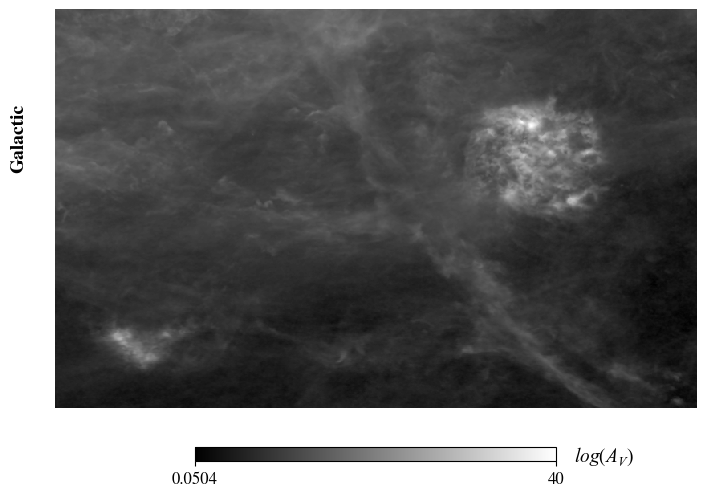

In [145]:
#====== For Plotting ======#
lmc_glon = [270., 307.]
lmc_glat = [-48., -25.]
glon_cen = (lmc_glon[0]+lmc_glon[1])/2.
glat_cen = (lmc_glat[0]+lmc_glat[1])/2.

title = r'$E(B-V)$'
hp.cartview(Av_map, title='', coord=['G'], unit=r'$log(A_V)$', nest=False, norm='log',
            lonra=lmc_glon, latra=lmc_glat, cmap='gray', cbar=True)

hp.projplot(mc_src_gl, mc_src_gb, 'bx', lonlat=True, coord='G')

mpl.rcParams.update({'font.size':12})
plt.grid()
plt.show()

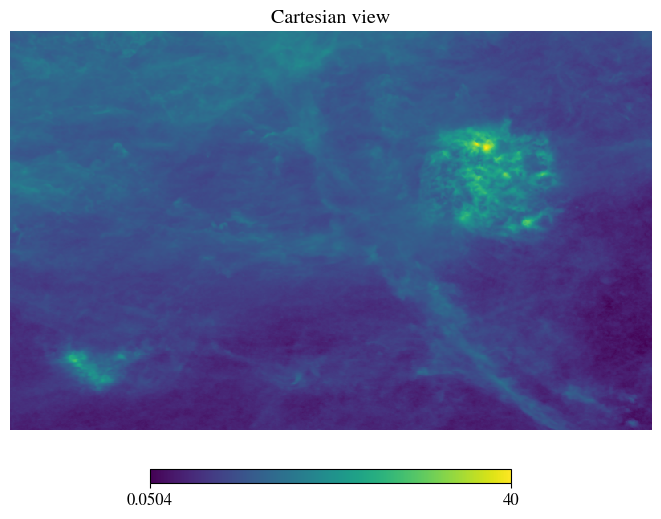

In [146]:
test = hp.cartview(Av_map, return_projected_map=True, lonra=lmc_glon, latra=lmc_glat, norm='log')
plt.show()

## $A_V$, $F_{CNM}$, $N_{HI}$ and coordinates

In [148]:
fcnm = mc_fg_res_df['fcnm'].values
sigfcnm = mc_fg_res_df['sigfcnm'].values
fcnm.shape

(462,)

In [149]:
nhi = mc_fg_res_df['nhi'].values
signhi = mc_fg_res_df['signhi'].values
nhi.shape

(462,)

In [150]:
mc_fg_cpn_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'taucnm', 'sigtaucnm',
       'sigtaunoise', 'cencnm', 'sigcencnm', 'widcnm', 'sigwidcnm', 'tscnm',
       'sigtscnm', 'tbcnm', 'sigtbcnm', 'nhicnm_cpn', 'signhicnm_cpn',
       'fcnm_cpn', 'sigfcnm_cpn', 'nhi_tot', 'signhi_tot', 'tsky',
       'nhicnm_avg', 'signhicnm_avg'],
      dtype='object')

# $F_{CNM}$ vs $A_V$: far from LMC and SMC

In [165]:
LMC_center_gl = cf.LMC['gl'] # deg
LMC_center_gb = cf.LMC['gb'] # deg

r_lmc_thresh = 6. # degrees
r_smc_thresh = 4. # degrees

d_from_LMC = np.sqrt((mc_src_gl-LMC_center_gl)**2 + (mc_src_gb-LMC_center_gb)**2)
d_from_SMC = np.sqrt((mc_src_gl-SMC_center_gl)**2 + (mc_src_gb-SMC_center_gb)**2)

id_far = np.where( (d_from_LMC > r_lmc_thresh) & (d_from_SMC > r_smc_thresh))[0]

glon_far = mc_src_gl[id_far]
glat_far = mc_src_gb[id_far]

fcnm_far = fcnm[id_far]
sigfcnm_far = sigfcnm[id_far]

ew_far = ew[id_far]
sigew_far = sigew[id_far]

ewfit_far = ewfit[id_far]
sigewfit_far = sigewfit[id_far]

tau353_far = tau353[id_far]
sigtau353_far = sigtau353[id_far]

Av_far = Av[id_far]
sigAv_far = sigAv[id_far]

pl_Av_far = pl_Av[id_far]
pl_sigAv_far = pl_sigAv[id_far]

tdust_far = tdust[id_far]
sigtdust_far = sigtdust[id_far]

nhi_far = nhi[id_far]
signhi_far = signhi[id_far]

nhi_near = nhi[id_near]
signhi_near = signhi[id_near]

beta_far = beta[id_far]
sigbeta_far = sigbeta[id_far]


id_near = np.where( (d_from_LMC <= r_lmc_thresh) | (d_from_SMC <= r_smc_thresh))[0]
glon_near = mc_src_gl[id_near]
glat_near = mc_src_gb[id_near]

fcnm_near = fcnm[id_near]
sigfcnm_near = sigfcnm[id_near]

Av_near = Av[id_near]
sigAv_near = sigAv[id_near]

In [ ]:
r, p = scipy.stats.pearsonr(src_av, nhi)
print(r, p)

0.7320610242709856 1.0537956226891494e-78


In [ ]:
from scipy.optimize import curve_fit

# Define the model function with intercept = 0
def linear_model(x, slope):
    return slope * x

# Perform the fit
popt, pcov = curve_fit(linear_model, Av_far, nhi_far)

# Extract the slope and its uncertainty
slope = popt[0]
slope_err = np.sqrt(pcov[0, 0])

# Generate the y-values based on the fit
av_x = np.linspace(0.07, 0.55, 20)
y_fit = linear_model(av_x, slope)

In [ ]:
print(slope, slope_err)

23.31603032733176 0.2230833099553788


In [ ]:
from scipy.optimize import curve_fit

# Define the model function with intercept = 0
def linear_model(x, slope):
    return slope * x

# Perform the fit
popt, pcov = curve_fit(linear_model, pl_Av_far, nhi_far)

# Extract the slope and its uncertainty
slope = popt[0]
slope_err = np.sqrt(pcov[0, 0])

# Generate the y-values based on the fit
av_x = np.linspace(0.07, 0.55, 20)
y_fit_pl = linear_model(av_x, slope)

print(slope, slope_err)

20.68282499517744 0.2269392079686776


In [ ]:
# Perform the fit
popt, pcov = curve_fit(linear_model, src_av, nhi)

# Extract the slope and its uncertainty
slope = popt[0]
slope_err = np.sqrt(pcov[0, 0])

# Generate the y-values based on the fit
av_x = np.linspace(0.07, 0.55, 20)
y_fit1 = linear_model(av_x, slope)

In [ ]:
print(slope, slope_err)

28.25209241990691 0.29943282124044796


In [ ]:
print(np.min(src_av), np.mean(src_av), np.median(src_av), np.max(src_av))
print(np.min(Av_far), np.mean(Av_far), np.median(Av_far), np.max(Av_far))

0.06509340554475784 0.20936308185130487 0.210504949092865 0.3878185451030731
0.08529326 0.27406546 0.26053077 0.4808192


In [176]:
mc_fg_res_df['d_lmc'] = d_from_LMC.tolist()
mc_fg_res_df['d_smc'] = d_from_SMC.tolist()
mc_fg_res_df.head()

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sgd_av,sgd_sigav,pl_av,pl_sigav,tau353,sigtau353,pl_ebv,pl_sigebv,d_lmc,d_smc
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.113332,0.009067,0.092318,0.002326,0.000002,3.028322e-08,0.029780,0.000750,26.512638,1.551564
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,0.289597,0.023168,0.378468,0.020998,0.000008,4.236099e-07,0.122086,0.006774,24.294786,1.215275
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.116612,0.009329,0.144968,0.005839,0.000003,1.094777e-07,0.046764,0.001883,27.764968,2.274865
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.122936,0.009835,0.112433,0.002947,0.000002,4.083836e-08,0.036269,0.000951,25.188587,1.631716
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,...,0.154984,0.012399,0.190356,0.006140,0.000004,1.038593e-07,0.061405,0.001981,25.570722,3.135291


In [177]:
if False:
    print(MC_fg_gfit_res_file)
    mc_fg_res_df.to_csv(MC_fg_gfit_res_file, index=False)

In [178]:
tau353_far = tau353[id_far]
sigtau353_far = sigtau353[id_far]
len(sigtau353_far)

290

In [179]:
nnear = len(id_near)
nfar  = len(id_far)
print(f'N-near, N-far: {nnear, nfar}')

N-near, N-far: (172, 290)


In [180]:
nnear + nfar

462

In [181]:
nhi_far = nhi[id_far]
signhi_far = signhi[id_far]

nhi_near = nhi[id_near]
signhi_near = signhi[id_near]

In [182]:
tsmean_far = tspin_mean[id_far]
sigtsmean_far = sigtspin_mean[id_far]

tsmean_near = tspin_mean[id_near]
sigtsmean_near = sigtspin_mean[id_near]

In [183]:
scattering_high_av_id = np.where(Av_far > 0.35)[0]
av_high = Av_far[scattering_high_av_id]
sigav_high = sigAv_far[scattering_high_av_id]
nhi_high_av = nhi_far[scattering_high_av_id]
signhi_high_av = signhi_far[scattering_high_av_id]

glon_high_av = glon_far[scattering_high_av_id]
glat_high_av = glat_far[scattering_high_av_id]

In [184]:
nabs_sources - len(id_near)

290

In [190]:
dens_ratio = Av_far / nhi_far

sigfcnm_log10 = sigfcnm/fcnm/np.log(10)
sigAv_log10 = sigAv/Av/np.log(10)


sigfcnm_far_log10 = sigfcnm_far/fcnm_far/np.log(10)
sigAv_far_log10 = sigAv_far/Av_far/np.log(10)

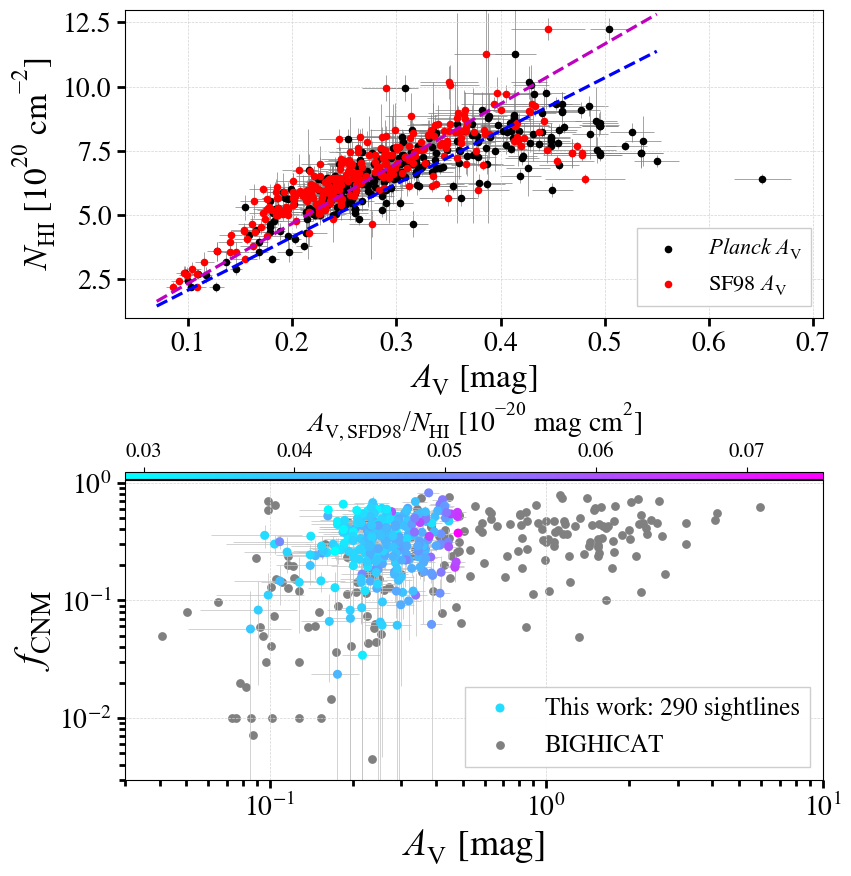

In [215]:
# Set the font family for math symbols
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

from mpl_toolkits.axes_grid1 import make_axes_locatable


cm = mpl.cm.get_cmap('cool') 


xylbsize = 24
xytlbsize = 20
lgsize = 20


fig = plt.figure(figsize=(9,10))

ax = fig.add_subplot(211)



ax.errorbar(pl_Av_far, nhi_far,
             xerr=pl_sigAv_far, yerr=signhi_far, zorder=1, 
             color='gray', marker='o', ls='None', markersize=2,
             markeredgecolor='gray', markeredgewidth=1,
             ecolor='gray', elinewidth=0.5,
             label='')

ax.scatter(pl_Av_far, nhi_far,
                   zorder=2, s=20,
                   marker='o', c='k',
                   label=r'$Planck$ $A_\mathrm{V}$') 


ax.errorbar(Av_far, nhi_far,
             xerr=sigAv_far, yerr=signhi_far, zorder=1, 
             color='gray', marker='o', ls='None', markersize=2,
             markeredgecolor='gray', markeredgewidth=1,
             ecolor='gray', elinewidth=0.5,
             label='')

ax.scatter(Av_far, nhi_far,
                   zorder=2, s=20,
                   marker='o', c='r',
                   label=r'SF98 $A_\mathrm{V}$')



ax.plot(av_x, y_fit_pl, color='b', lw=2.3, ls='--', label='')
ax.plot(av_x, y_fit, color='m', lw=2.3, ls='--', label='')



ax.set_xlabel(r'$A_\mathrm{V}$ [mag]', fontsize=xylbsize) # Visual Extinction 
ax.set_ylabel(r'$N_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=xylbsize, fontweight='normal') # 

ax.set_ylim(1., 13.)

ax.tick_params(axis='x', labelsize=xytlbsize, pad=4)
ax.tick_params(axis='y', labelsize=xytlbsize)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax.legend(loc='lower right', fancybox=False, framealpha=0.99, labelcolor='k', fontsize=16)










ax3 = fig.add_subplot(212)

color_ = 'k'
ax3.errorbar(Av_far, fcnm_far,
             xerr=sigAv_far_log10, yerr=sigfcnm_far_log10, zorder=1, 
             color='silver', marker='o', ls='None', markersize=4,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')

sct1 = ax3.scatter(Av_far, fcnm_far,
                   zorder=2, s=30,
                   marker='o', c=dens_ratio, cmap=cm, vmin=dens_ratio.min(), vmax=dens_ratio.max(),
                   facecolors='none',
                   label=f'This work: {len(Av_far)} sightlines') # (sightlines toward LMC+SMC excluded)

ax3.scatter(bighicat_av, bighicat_fcnm,
                   zorder=0, s=28,
                   marker='o', c='gray',
                   label=f'BIGHICAT')


ax3.set_xscale('log')
ax3.set_yscale('log')

ax3.set_xlabel(r'$A_\mathrm{V}$ [mag]', fontsize=xylbsize+3)
ax3.set_ylabel(r'$f_\mathrm{CNM}$', fontsize=xylbsize+4)

ax3.set_xlim(3.e-2, 10.)
ax3.set_ylim(3.e-3, 1.05)

ax3.tick_params(axis='x', labelsize=xytlbsize, pad=4)
ax3.tick_params(axis='y', labelsize=xytlbsize)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=6)
ax3.tick_params(which='minor', length=4)

ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower right', fancybox=False, framealpha=0.95, labelcolor='k', fontsize=18)




# Create a gridspec for the colorbar
divider = make_axes_locatable(ax3)
cbar_ax = divider.append_axes("top", size="2.5%", pad=0.01)

# Color bar
cbar = fig.colorbar(sct1, cax=cbar_ax, orientation='horizontal', fraction=0.1, pad=0.005, aspect=60)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$A_\mathrm{V,SFD98}/N_\mathrm{HI}$ [10$^{-20}$ mag cm$^{2}$]', labelpad=8., fontsize=20)



# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.0,
                    hspace=0.5
                    )


plt.show()

In [224]:
print(Av_far.min(), np.mean(Av_far), np.median(Av_far), Av_far.max())

0.08529326 0.27406546 0.26053077 0.4808192


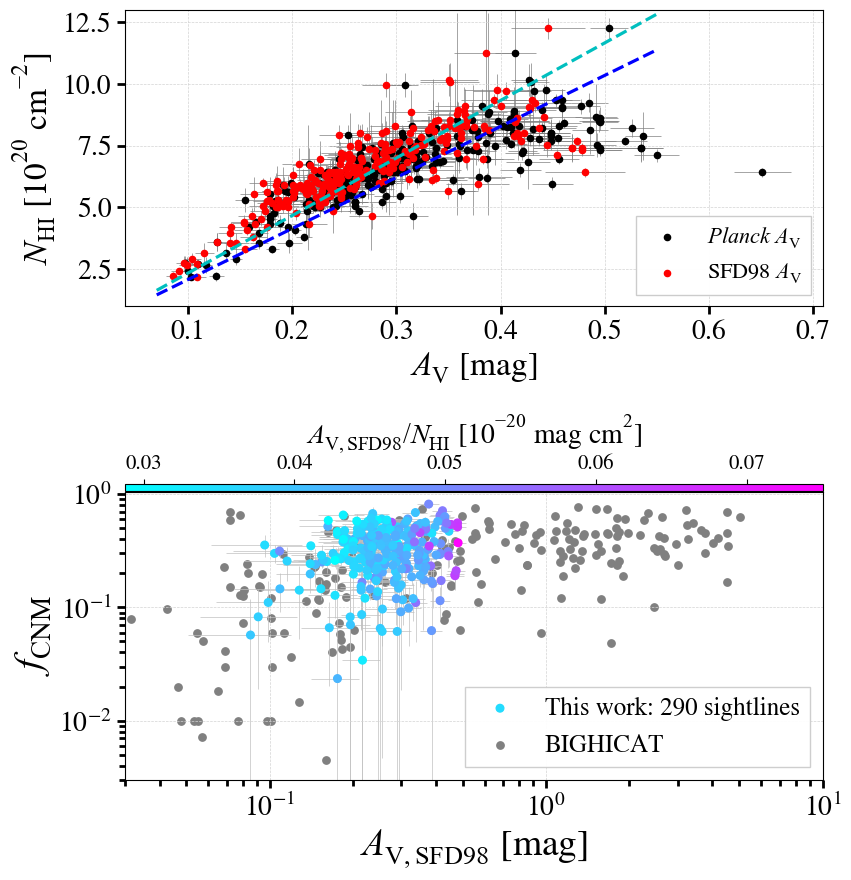

In [222]:
# Set the font family for math symbols
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

from mpl_toolkits.axes_grid1 import make_axes_locatable


xylbsize = 24
xytlbsize = 20
lgsize = 20


fig = plt.figure(figsize=(9,10))

ax = fig.add_subplot(211)



ax.errorbar(pl_Av_far, nhi_far,
             xerr=pl_sigAv_far, yerr=signhi_far, zorder=1, 
             color='gray', marker='o', ls='None', markersize=2,
             markeredgecolor='gray', markeredgewidth=1,
             ecolor='gray', elinewidth=0.5,
             label='')

ax.scatter(pl_Av_far, nhi_far,
                   zorder=2, s=20,
                   marker='o', c='k',
                   label=r'$Planck$ $A_\mathrm{V}$')


ax.errorbar(Av_far, nhi_far,
             xerr=sigAv_far, yerr=signhi_far, zorder=1, 
             color='gray', marker='o', ls='None', markersize=2,
             markeredgecolor='gray', markeredgewidth=1,
             ecolor='gray', elinewidth=0.5,
             label='')

ax.scatter(Av_far, nhi_far,
                   zorder=2, s=20,
                   marker='o', c='r', 
                   label=r'SFD98 $A_\mathrm{V}$')



ax.plot(av_x, y_fit_pl, color='blue', lw=2.3, ls='--', label='')
ax.plot(av_x, y_fit, color='c', lw=2.3, ls='--', label='')



ax.set_xlabel(r'$A_\mathrm{V}$ [mag]', fontsize=xylbsize) # Visual Extinction 
ax.set_ylabel(r'$N_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=xylbsize, fontweight='normal') # 

ax.set_ylim(1., 13.)

ax.tick_params(axis='x', labelsize=xytlbsize, pad=4)
ax.tick_params(axis='y', labelsize=xytlbsize)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax.legend(loc='lower right', fancybox=False, framealpha=0.99, labelcolor='k', fontsize=16)










ax3 = fig.add_subplot(212)

color_ = 'k'
ax3.errorbar(Av_far, fcnm_far,
             xerr=sigAv_far_log10, yerr=sigfcnm_far_log10, zorder=1, 
             color='silver', marker='o', ls='None', markersize=4,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')

sct1 = ax3.scatter(Av_far, fcnm_far,
                   zorder=2, s=30,
                   marker='o', c=dens_ratio, cmap=cm, vmin=dens_ratio.min(), vmax=dens_ratio.max(),
                   facecolors='none',
                   label=f'This work: {len(Av_far)} sightlines') # (sightlines toward LMC+SMC excluded)

ax3.scatter(bighicat_Av, bighicat_fcnm,
                   zorder=0, s=28,
                   marker='o', c='gray',
                   label=f'BIGHICAT')


ax3.set_xscale('log')
ax3.set_yscale('log')

ax3.set_xlabel(r'$A_\mathrm{V,SFD98}$ [mag]', fontsize=xylbsize+3)
ax3.set_ylabel(r'$f_\mathrm{CNM}$', fontsize=xylbsize+4)

ax3.set_xlim(3.e-2, 10.)
ax3.set_ylim(3.e-3, 1.05)

ax3.tick_params(axis='x', labelsize=xytlbsize, pad=4)
ax3.tick_params(axis='y', labelsize=xytlbsize)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=6)
ax3.tick_params(which='minor', length=4)

ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower right', fancybox=False, framealpha=0.95, labelcolor='k', fontsize=18)




# Create a gridspec for the colorbar
divider = make_axes_locatable(ax3)
cbar_ax = divider.append_axes("top", size="2.5%", pad=0.01)

# Color bar
cbar = fig.colorbar(sct1, cax=cbar_ax, orientation='horizontal', fraction=0.1, pad=0.005, aspect=60)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$A_\mathrm{V,SFD98}/N_\mathrm{HI}$ [10$^{-20}$ mag cm$^{2}$]', labelpad=8., fontsize=20)



# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.0,
                    hspace=0.6
                    )
plt.show()